In [1]:
import os
import shutil
import pickle
import numpy as np
import torch
import copy
import matplotlib.pyplot as plt

from skopt.optimizer import gp_minimize
from skopt.space import Real, Categorical, Integer

from bcnf.simulation.physics import get_data
from bcnf.models.cnf import CondRealNVP
from bcnf.models.feature_network import FullyConnectedFeatureNetwork
from bcnf.eval.crossvalidate import cross_validate
from bcnf.errors import TrainingDivergedError

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
np.int = np.int64

In [3]:
# Check if a checkpoint exists
checkpoint_file = 'checkpoint.pkl'
metrics_dir = 'metrics'
os.makedirs(metrics_dir, exist_ok=True)

In [4]:
X, y = get_data(
    T=1.0,
    dt=1 / 30,
    N=2_000,
    break_on_impact=False
)

X_tensor = torch.Tensor(X.reshape(X.shape[0], -1))
y_tensor = torch.Tensor(y)

100%|██████████| 2000/2000 [00:01<00:00, 1103.35it/s]


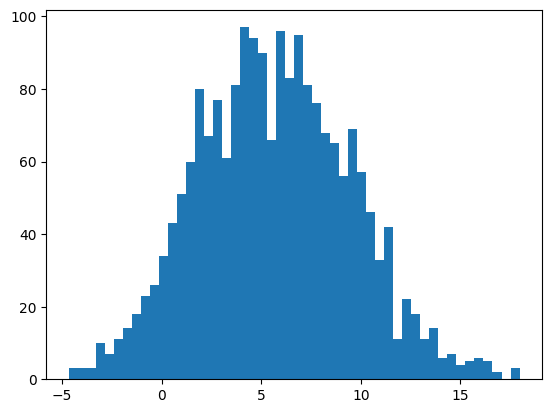

In [5]:
plt.hist(X_tensor[:, -1].numpy().flatten(), bins=50);

In [6]:
optimizer_kwargs = {
    "lr": 2e-4
}

lr_scheduler_kwargs = {
    "mode": "min",
    "factor": 0.5,
    "patience": 200,
    "threshold": 1e-3,
}

In [7]:
# Example search spaces
search_spaces = {
    'condition_size': Integer(1, 2048),
    'model_hidden_size': Integer(32, 256),
    'model_n_blocks': Integer(1, 32),
    'model_act_norm': Categorical([True, False]),
    'feature_network_hidden_size': Integer(16, 2048),
    'feature_network_hidden_layers': Integer(0, 16),
    'feature_network_dropout': Real(0, 0.5),
}

In [8]:
def param_index(name, search_spaces):
    return list(search_spaces.keys()).index(name)

In [9]:
model_size = y_tensor.shape[1]
feature_size = X_tensor.shape[1]

In [10]:
def score_parameters(params: list):
    print(params)
    try:
        fold_metrics = cross_validate(
            model_class=CondRealNVP,
            model_kwargs={
                "size": model_size,
                "hidden_size": params[param_index('model_hidden_size', search_spaces)],
                "n_blocks": params[param_index('model_n_blocks', search_spaces)],
                "n_conditions": params[param_index('condition_size', search_spaces)],
                "act_norm": params[param_index('model_act_norm', search_spaces)],
            },
            feature_network_class=FullyConnectedFeatureNetwork,
            feature_network_kwargs={
                "sizes": [feature_size]
                    + [params[param_index('feature_network_hidden_size', search_spaces)]] * params[param_index('feature_network_hidden_layers', search_spaces)]
                    + [params[param_index('condition_size', search_spaces)]],
                "dropout": params[param_index('feature_network_dropout', search_spaces)],    
            },
            optimizer_class=torch.optim.Adam,
            optimizer_kwargs=optimizer_kwargs,
            lr_scheduler_class=torch.optim.lr_scheduler.ReduceLROnPlateau,
            lr_scheduler_kwargs=lr_scheduler_kwargs,
            X=X_tensor,
            y=y_tensor,
            n_epochs=50_000,
            val_loss_patience=500,
            val_loss_tolerance=1e-3,
            timeout=60 * 60,  # 1 hour
            batch_size=256,
            device=device,
            verbose=True,
            n_splits=3,
            errors="raise"
        )

        # Save the metrics
        with open(f'{metrics_dir}/params_{"_".join([str(p) for p in params])}.pkl', 'wb') as f:
            pickle.dump(fold_metrics, f)

    except TrainingDivergedError as e:
        print(e)
        return 100  # A big number

    val_loss_list = [r['val_loss'][1] for r in fold_metrics]  # each val_loss value is a tuple (epoch, loss)
    print(f'Val Loss: {np.mean(val_loss_list):.4f} ± {np.std(val_loss_list):.4f}')
    return np.mean(val_loss_list) + np.std(val_loss_list)

In [11]:
# Define a callback function to save the results
def save_checkpoint(result):
    # Save the checkpoint after each iteration or at the end of the optimization
    with open(checkpoint_file + ".tmp", 'wb') as f:
        # Ignore
        # - result['specs']['args']['func']
        # - result['specs']['args']['callback']
        # because it causes problems when reading somewhere else
        result_no_func = copy.deepcopy(result)
        del result_no_func['specs']['args']['func']
        del result_no_func['specs']['args']['callback']
        pickle.dump(result_no_func, f)

    # Delete the old checkpoint file and rename the temporary file
    shutil.move(checkpoint_file + ".tmp", checkpoint_file)

In [12]:
N_STEPS = 100

In [13]:
if os.path.exists(checkpoint_file):
    print(f'Loading checkpoint from {checkpoint_file}')
    with open(checkpoint_file, 'rb') as f:
        checkpoint = pickle.load(f)
        checkpoint['specs']['args']['func'] = score_parameters
        checkpoint['specs']['args']['callback'] = save_checkpoint
    print(f'Resuming from iteration {len(checkpoint.x_iters)}')
else:
    print('No checkpoint found. Starting new optimization')
    checkpoint = None

# You might want to adjust the n_calls or other parameters based on the checkpoint
result = gp_minimize(
    func=score_parameters,
    dimensions=search_spaces.values(),
    n_initial_points=10,
    n_calls=N_STEPS - len(checkpoint.x_iters) if checkpoint else N_STEPS,
    random_state=2024_03_25,
    verbose=True,
    callback=save_checkpoint,
    x0 = checkpoint.x_iters if checkpoint else None,
    y0 = checkpoint.func_vals if checkpoint else None)

No checkpoint found. Starting new optimization
Iteration No: 1 started. Evaluating function at random point.
[424, 146, 10, True, 309, 6, 0.20216911190275677]


Train: -28.8342 - Val: -28.2171 (avg: -29.4692, min: -29.7685) | lr: 2.00e-04 - Patience: 7/500:   5%|▍         | 2325/50000 [02:28<51:39, 15.38it/s]   